    This notebook comprises of my work w.r.t URL Categorization Model 2.0 .  We have added some category specific features
    to capture the specific information in the Category. 
    

# Load Libraries

In [1]:
from netaddr import valid_ipv4
import ipaddress
from urllib.parse import urlparse
import pandas as pd
import configparser
import numpy as np
import warnings
import logging
import pickle
import json
import os
import re
import math
import time
from collections import Counter

In [28]:
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer

In [162]:
from multiprocessing import Pool
import swifter
import nltk

In [199]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 999)

# Utilities Functions

## Feature Set-I

### Hard Coded Features

In [253]:
shop = [
    'shop', 'store', 'category', 'sale', 'gift', 'ebay', 'cart', 'auction',
    'catalog', 'amazon', 'brand', 'wholesale', 'kmart', 'shopping', 'buy',
    'offer', 'bestbuy', 'browse', 'ikea', 'boutique', 'grabon', 'forsale',
    'bonanza', 'market', 'balance', 'bid', 'gap', 'deal', 'shoes', 'olx',
    'nike', 'adidas', 'myntra', 'flipkart', 'dress', 'naptol', 'rakuten',
    'jabong', 'firstcry', 'alibaba', 'target', 'factory', 'home', 'dhamaal',
    'collect', 'novelty', 'furniture'
]

news = [
    'news', 'headline', 'herald', 'article', 'journal', 'press', 'tribune',
    'sentinel', 'view', 'magazines', 'report', 'gazette', 'daily', 'info',
    'feed', 'section', 'page', 'world', 'times', '24', '7'
]

information_security = [
    'information', 'security', 'cyber', 'threat', 'protect', 'software',
    'solution', 'vulnerability', 'intelligence', 'anti', 'soft', 'cisco',
    'mcafee', 'authentication', 'norton', 'network', 'detection', 'hacker',
    'theft', 'online', 'encryption', 'net', 'digital', 'app', 'malware',
    'mobile', 'windows', 'system', 'feature', 'lock', 'library', 'site', 'web',
    'research', 'center', 'resourse', 'lab', 'tech', 'wireless', 'endpoint',
    'response', 'cloud', 'computer'
]

games = [
    'game', 'puzzle', 'chess', 'sudoku', 'cheat', 'craft', 'sega', 'nintendo',
    'ops', 'black', 'duty', 'call', 'monster', 'crack', 'pc', 'play', 'hero',
    'cry', 'pokemon', 'team', 'emulator', 'batman', 'quize', 'toy', 'vortex',
    'forum', 'portal', 'stream', 'room', 'rock', 'zone', 'card'
]

entertainment = [
    'celebrity', 'movie', 'entertainment', 'music', 'drama', 'theatre',
    'hollywood', 'bollywood', 'video', 'film', 'radio', 'imdb', 'lyric',
    'production', 'dance', 'song', 'photo', 'gallery', 'television', 'actor',
    'comedy', 'poem', 'episode', 'classic', 'cartoon', 'serial', 'performance',
    'hindi', 'tv', 'costume', 'star', 'award', 'cinema'
]

education = [
    'edu', 'school', 'study', 'geek', 'learn', 'train', 'course', 'college',
    'exam', 'science', 'academic', 'math', 'scholarship', 'student',
    'admission', 'knowledge', 'teach', 'engineering', 'skill', 'read', 'write',
    'curriculum', 'professor', 'educate', 'university', 'classroom', 'guide',
    'coach'
]

business = [
    'business', 'market', 'industry', 'trade', 'alibaba', 'company', 'ltd',
    'startup', 'entrepreneur', 'manage', 'pvt', 'retail', 'manufacturing',
    'finance', 'ecommerce', 'expo', 'mfg', 'purchase', 'promo', 'corp'
]

arts = [
    'india', 'draw', 'folk', 'paint', 'candle', 'tribal', 'puppet', 'balloon',
    'pottery', 'cultur', 'art', 'graffiti', 'creat', 'sculpture', 'clay',
    'wood', 'origami', 'design', 'doodle', 'dye', 'quil', 'sand', 'ink', 'mud'
]

dating = [
    'dat', 'shaadi', 'matrimon', 'saathi', 'love', 'cupid', 'couple',
    'marriage', 'marry', 'single', 'partner', 'match'
]

wepons = [
    'knife', 'ninja', 'sword', 'gun', 'weapon', 'arm', 'cannon', 'fire',
    'defence', 'dagger', 'knive', 'ammo', 'missile', 'sniper', 'military',
    'bomb', 'rifle', 'pistol', 'martialart', 'hunter'
]

### Rest Features 

In [150]:
def parallelize_dataframe(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [254]:
pos_family = {
    'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
    'pron': ['PRP', 'PRP$', 'WP', 'WP$'],
    'verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
    'adj': ['JJ', 'JJR', 'JJS'],
    'adv': ['RB', 'RBR', 'RBS', 'WRB']
}


def check_pos_tag(x, flag):
    cnt = 0
    try:
        k = pd.Series([
            list(x)[1] for x in nltk.pos_tag(nltk.word_tokenize(str(x)))
        ]).value_counts()
        for i in pos_family[flag]:
            if i in k.index.tolist():
                cnt = cnt + k[i]
    except:
        pass
    return cnt



def sensitive_word_count(url, sensitive_list):
    count = 0
    for i in sensitive_list:
        if url.find(i) != -1:
            count += 1
    return count


def security_sensitive(url):
    count = 0
    for i in security_sensitive_words:
        if url.find(i) != -1:
            count += 1
    return count


def check_Presence_of_IP_address_in_Hostname(x):
    try:
        ipaddress.ip_address(x)
        return 1
    except:
        return 0


def Tokenise(url):

    if url == '':
        return [0, 0, 0]
    token_word = re.split('\W+', url)

    no_elements = sum_length = largest_element = 0
    for ele in token_word:
        l = len(ele)
        sum_length += l
        if l > 0:
            no_elements += 1
        if largest_element < l:
            largest_element = l
    try:

        return no_elements
    except:

        return no_elements


def sensitive_word_count(url, sensitive_list):
    count = 0
    for i in sensitive_list:
        if url.find(i) != -1:
            count += 1
    return count


def non_www_url(url):
    if url.find('www.') != -1:
        return 1
    return 0


def entropy(s):
    l = float(len(s))
    return (-sum(map(lambda a: (a / l) * math.log2(a / l),
                     Counter(s).values())))


def get_email_domain(string):
    domain = re.search("@[\w.]+", string)
    if domain is None:
        return None
    return str(domain.group())[1:]


def get_url_domain(url):
    domain = None
    if url:
        if u'@' in str(url):
            domain = get_email_domain(str(url))
        else:
            parsed_uri = urlparse(url)
            domain = '{uri.netloc}'.format(uri=parsed_uri)
            if domain.startswith("www."):
                return domain[4:]
    return domain


In [169]:
def word_pos_feature(data):
    feature_pos_count = pd.DataFrame()
    feature_pos_count['noun_count'] = data[
        'text_data'].swifter.set_npartitions(8).apply(
            lambda x: check_pos_tag(x, 'noun'))
    feature_pos_count['verb_count'] = data[
        'text_data'].swifter.set_npartitions(8).apply(
            lambda x: check_pos_tag(x, 'verb'))
    feature_pos_count['adj_count'] = data['text_data'].swifter.set_npartitions(
        8).apply(lambda x: check_pos_tag(x, 'adj'))
    feature_pos_count['adv_count'] = data['text_data'].swifter.set_npartitions(
        8).apply(lambda x: check_pos_tag(x, 'adv'))
    feature_pos_count['pron_count'] = data[
        'text_data'].swifter.set_npartitions(8).apply(
            lambda x: check_pos_tag(x, 'pron'))
    feature_pos_count['noun_count_url'] = data[
        'pre_processed_url'].swifter.set_npartitions(8).apply(
            lambda x: check_pos_tag(x, 'noun'))
    feature_pos_count[
        'verb_count_url'] = data.pre_processed_url.swifter.set_npartitions(
            8).apply(lambda x: check_pos_tag(x, 'verb'))
    feature_pos_count['adj_count_url'] = data[
        'pre_processed_url'].swifter.set_npartitions(8).apply(
            lambda x: check_pos_tag(x, 'adj'))
    feature_pos_count['adv_count_url'] = data[
        'pre_processed_url'].swifter.set_npartitions(8).apply(
            lambda x: check_pos_tag(x, 'adv'))
    feature_pos_count['pron_count_url'] = data[
        'pre_processed_url'].swifter.set_npartitions(8).apply(
            lambda x: check_pos_tag(x, 'pron'))

    return feature_pos_count


def check_count(data):
    specific_word_count_df = pd.DataFrame()
    specific_word_count_df[
        'Shop'] = data.pre_processed_url.swifter.set_npartitions(8).apply(
            lambda x: sensitive_word_count(x, shop))

    specific_word_count_df[
        'news'] = data.pre_processed_url.swifter.set_npartitions(8).apply(
            lambda x: sensitive_word_count(x, news))

    specific_word_count_df[
        'information_security'] = data.pre_processed_url.swifter.set_npartitions(
            8).apply(lambda x: sensitive_word_count(x, information_security))

    specific_word_count_df[
        'games'] = data.pre_processed_url.swifter.set_npartitions(8).apply(
            lambda x: sensitive_word_count(x, games))

    specific_word_count_df[
        'entertainment'] = data.pre_processed_url.swifter.set_npartitions(
            8).apply(lambda x: sensitive_word_count(x, entertainment))

    specific_word_count_df[
        'education'] = data.pre_processed_url.swifter.set_npartitions(8).apply(
            lambda x: sensitive_word_count(x, education))

    specific_word_count_df[
        'business'] = data.pre_processed_url.swifter.set_npartitions(8).apply(
            lambda x: sensitive_word_count(x, business))

    specific_word_count_df[
        'arts'] = data.pre_processed_url.swifter.set_npartitions(8).apply(
            lambda x: sensitive_word_count(x, arts))

    #     specific_word_count_df['word_sense'] = data.pre_processed_url.apply(
    #         lambda x: sensitive_word_count(x, word_sense))

    #     specific_word_count_df['add_on_count'] = np.array(
    #         data.pre_processed_url.apply(
    #             lambda x: sensitive_word_count(x, add_on))).copy()

    specific_word_count_df['dating_count'] = np.array(
        data.pre_processed_url.swifter.set_npartitions(8).apply(
            lambda x: sensitive_word_count(x, dating))).copy()

    specific_word_count_df['weapons_count'] = np.array(
        data.pre_processed_url.swifter.set_npartitions(8).apply(
            lambda x: sensitive_word_count(x, wepons))).copy()

    return specific_word_count_df


def add_static_url_features(data):
    # print('@223 : Inside add_static_url_features @',
    #      time.strftime("%H:%M:%S", time.localtime()))
    url_features = pd.DataFrame()
    url_features['url_length'] = data.url.swifter.set_npartitions(8).apply(
        lambda x: len(str(x))).copy()
    url_features['is_IP_address'] = data.url.swifter.set_npartitions(8).apply(
        lambda x: check_Presence_of_IP_address_in_Hostname(x)).copy()
    url_features[
        'length_of_query_string_in_URL'] = data.url.swifter.set_npartitions(
            8).apply(lambda x: len(urlparse(str(x)).query)).copy()
    url_features['token_count'] = data.url.swifter.set_npartitions(8).apply(
        lambda x: Tokenise(x)).copy()
    url_features['no_of_dots'] = data.url.swifter.set_npartitions(8).apply(
        lambda x: str(x).count('.')).copy()
    url_features['no_of_hyphen'] = data.url.swifter.set_npartitions(8).apply(
        lambda x: str(x).count('-')).copy()
    url_features['no_of_underscore'] = data.url.swifter.set_npartitions(
        8).apply(lambda x: str(x).count('_')).copy()
    url_features['no_of_equal'] = data.url.swifter.set_npartitions(8).apply(
        lambda x: str(x).count('=')).copy()
    url_features['no_of_forward_slash'] = data.url.swifter.set_npartitions(
        8).apply(lambda x: str(x).count('/')).copy()
    url_features['no_of_question_marks'] = data.url.swifter.set_npartitions(
        8).apply(lambda x: str(x).count('?')).copy()
    url_features['no_of_semicolon'] = data.url.swifter.set_npartitions(
        8).apply(lambda x: str(x).count(';')).copy()
    url_features['no_of_open_parenthesis'] = data.url.swifter.set_npartitions(
        8).apply(lambda x: str(x).count('(')).copy()
    url_features['no_of_mod'] = data.url.swifter.set_npartitions(8).apply(
        lambda x: str(x).count('%')).copy()
    url_features['no_of_ampersand'] = data.url.swifter.set_npartitions(
        8).apply(lambda x: str(x).count('&')).copy()
    url_features['no_of_@'] = data.url.swifter.set_npartitions(8).apply(
        lambda x: str(x).count('@')).copy()
    url_features['no_of_double_slash'] = data.url.swifter.set_npartitions(
        8).apply(lambda x: str(x).count('//')).copy()
    #     url_features['no_of_sensetive_words'] = data.url.swifter.set_npartitions(
    #         8).apply(lambda x: security_sensitive(str(x))).copy()
    url_features['no_of_digits'] = data.url.swifter.set_npartitions(8).apply(
        lambda x: sum(c.isdigit() for c in x)).copy()
    url_features['url_entropy'] = data.url.swifter.set_npartitions(8).apply(
        lambda x: entropy(x)).copy()
    url_features['non_www_url'] = data.url.swifter.set_npartitions(8).apply(
        lambda x: non_www_url(x)).copy()
    url_features['domain_has_ip_addr'] = data.url.swifter.set_npartitions(
        8).apply(lambda x: len(
            re.findall(r'[0-9]+(?:\.[0-9]+){3}', get_url_domain(x)))).copy()
    return url_features

## Model Evaluate 

In [6]:
import pycm


def evaluate_model(Y_actual, Y_predicted):

    confusion_matrix_class = pycm.ConfusionMatrix(actual_vector=Y_actual,
                                                  predict_vector=Y_predicted)

    TPR = []
    PPV = []
    FPR = []
    FNR = []
    ACC = []
    F1 = []

    FP = confusion_matrix_class.FP.values()
    FN = confusion_matrix_class.FN.values()
    TP = confusion_matrix_class.TP.values()
    TN = confusion_matrix_class.TN.values()

    FPR_ = (sum(FP) / (sum(FP) + sum(TN)))
    FNR_ = (sum(FN) / (sum(FN) + sum(TP)))

    ACC_ = ((sum(TP) + sum(TN)) / (sum(FN) + sum(TP) + sum(TN) + sum(FP)))

    TPR.append(
        np.where((confusion_matrix_class.overall_stat['TPR Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['TPR Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['TPR Micro']))
    PPV.append(
        np.where((confusion_matrix_class.overall_stat['PPV Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['PPV Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['PPV Micro']))

    FPR.append(round(FPR_, 4))
    FNR.append(round(FNR_, 4))
    ACC.append(round(ACC_, 4))

    F1.append(
        np.where((confusion_matrix_class.overall_stat['F1 Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['F1 Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['F1 Micro']))

    for i in confusion_matrix_class.classes:

        TPR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['TPR'][i] == 'None')
                        |
                        (confusion_matrix_class.class_stat['TPR'][i] == np.nan
                         ), -0.99,
                        confusion_matrix_class.class_stat['TPR'][i])), 4))

        PPV.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['PPV'][i] == 'None')
                        |
                        (confusion_matrix_class.class_stat['PPV'][i] == np.nan
                         ), -0.99,
                        confusion_matrix_class.class_stat['PPV'][i])), 4))

        FPR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['FPR'][i] == 'None')
                        |
                        (confusion_matrix_class.class_stat['FPR'][i] == np.nan
                         ), -0.99,
                        confusion_matrix_class.class_stat['FPR'][i])), 4))
        FNR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['FNR'][i] == 'None')
                        |
                        (confusion_matrix_class.class_stat['FNR'][i] == np.nan
                         ), -0.99,
                        confusion_matrix_class.class_stat['FNR'][i])), 4))

        ACC.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['ACC'][i] == 'None')
                        |
                        (confusion_matrix_class.class_stat['ACC'][i] == np.nan
                         ), -0.99,
                        confusion_matrix_class.class_stat['ACC'][i])), 4))
        F1.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['F1'][i] == 'None')
                        |
                        (confusion_matrix_class.class_stat['F1'][i] == np.nan),
                        -0.99, confusion_matrix_class.class_stat['F1'][i])),
                4))

    eval_df = pd.DataFrame()
    index = ['overall']
    index.extend(confusion_matrix_class.classes)
    eval_df['Reccall'] = TPR
    eval_df['Precision'] = PPV
    eval_df['False_Positive_Rate'] = FPR
    eval_df['False_Negative_Rate'] = FNR
    eval_df['Accuracy'] = ACC
    eval_df['F1_Score'] = F1
    eval_df.index = index

    return (eval_df)

## Feature Set-II

### Density Based Features 

In [7]:
def extract_density_based_features(input_df, column='text_data'):
    feature_df = pd.DataFrame()

    feature_df['char_count'] = input_df[column].apply(len)
    feature_df['content_word_count'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: len(str(x).split(" ")))
    feature_df['word_density'] = feature_df['char_count'] / (
        feature_df['content_word_count'] + 1)
    feature_df['avg_word_length'] = feature_df['content_word_count'] / \
        (input_df[column].apply(len)+1)
    feature_df['noun_density'] = input_df[column].swifter.set_npartitions(
        8).apply(lambda x: check_pos_tag(x, 'noun')) / (
            feature_df['content_word_count'] + 1)
    feature_df['verb_density'] = input_df[column].swifter.set_npartitions(
        8).apply(lambda x: check_pos_tag(x, 'verb')) / (
            feature_df['content_word_count'] + 1)
    feature_df['adj_density'] = input_df[column].swifter.set_npartitions(
        8).apply(lambda x: check_pos_tag(x, 'adj')) / (
            feature_df['content_word_count'] + 1)
    feature_df['adv_density'] = input_df[column].swifter.set_npartitions(
        8).apply(lambda x: check_pos_tag(x, 'adv')) / (
            feature_df['content_word_count'] + 1)
    feature_df['pron_density'] = input_df[column].swifter.set_npartitions(
        8).apply(lambda x: check_pos_tag(x, 'pron')) / (
            feature_df['content_word_count'] + 1)
    feature_df['avg_pos_density'] = (feature_df[[
        'noun_density', 'verb_density', 'adj_density', 'adv_density',
        'pron_density'
    ]].sum(axis=1) / 5)
    return feature_df

### Uni-Gram Based Features 

![alt text](Feature_set_2_url_cat_2.PNG "Title")

In [115]:
def extract_word_count(input_df, column):
    cnt = Counter()
    for text in input_df[column].values:
        for word in text.split():
            cnt[word] += 1
    return cnt

In [117]:
def extract_top_n_non_common_uni_gram_words(input_df,
                                            column='text_data',
                                            set_a_tag=25,
                                            set_b_tag=19,
                                            top_n=10):
    cnt_set_a = extract_word_count(input_df[input_df.label == set_a_tag],
                                   column)
    cnt_set_b = extract_word_count(input_df[input_df.label == set_b_tag],
                                   column)
    return list(
        set([x[0] for x in cnt_set_a.most_common(top_n)]) -
        set([x[0] for x in cnt_set_b.most_common(top_n)]))

### Image || Gif || Video Based Features 

In [255]:
video_list = [
    '.webm', '.mpg', '.mp2', '.mpeg', '.mpe', '.mpv', '.ogg', '.mp4', '.m4p',
    '.m4v', '.avi', '.wmv', '.mov', '.qt'
    '.flv', '.swf', 'webm', 'mpg', 'mp2', 'mpeg', 'mpe', 'mpv', 'ogg', 'mp4',
    'm4p', 'm4v', 'avi', 'wmv', 'mov', 'qt'
    'flv', 'swf'
]

In [256]:
image_list = [
    '.jpg', '.jpeg', '.jpe', '.jif', '.jfif', '.jfi', '.png', '.webp', '.tiff',
    '.tif', '.psd', '.raw', '.arw', '.cr2', '.nrw', '.k25', '.bmp', '.dib',
    '.heif', '.heic', '.ind', '.indd', '.indt', '.jp2', '.j2k', '.jpf', '.jpx',
    '.jpm', '.mj2', '.svg', '.svgz', '.ai', '.eps', 'jpg', 'jpeg', 'jpe',
    'jif', 'jfif', 'jfi', 'png', 'webp', 'tiff', 'tif', 'psd', 'raw', 'arw',
    'cr2', 'nrw', 'k25', 'bmp', 'dib', 'heif', 'heic', 'ind', 'indd', 'indt',
    'jp2', 'j2k', 'jpf', 'jpx', 'jpm', 'mj2', 'svg', 'svgz', 'ai', 'eps'
]

In [257]:
gif_list = ['.gif','gif']

In [13]:
def count_word_presence(input_str, search_list):
    k = pd.Series(str(input_str).split()).value_counts()
    return k[list(set(list(k.index.values)).intersection(
        set(search_list)))].sum()

In [14]:
def image_gif_based_features(input_df, column='text_data'):
    feature_df = pd.DataFrame()
    feature_df['image_count'] = input_df[column].swifter.set_npartitions(
        8).apply(lambda x: count_word_presence(str(x).lower(), image_list))
    feature_df['gif_count'] = input_df[column].swifter.set_npartitions(
        8).apply(lambda x: count_word_presence(str(x).lower(), gif_list))
    feature_df['ratio_image_word'] = feature_df['image_count'] / (
        input_df[column].swifter.set_npartitions(8).apply(
            lambda x: len(str(x).split(" "))) + 1)
    feature_df['ratio_gif_word'] = feature_df['gif_count'] / (
        input_df[column].swifter.set_npartitions(8).apply(
            lambda x: len(str(x).split(" "))) + 1)
    feature_df['ratio_gif_image'] = feature_df['gif_count'] /\
        (feature_df['image_count']+1)
    feature_df['video_count'] = input_df[column].swifter.set_npartitions(
        8).apply(lambda x: count_word_presence(str(x).lower(), video_list))
    feature_df['ratio_video_word'] = feature_df['video_count'] / (
        input_df[column].swifter.set_npartitions(8).apply(
            lambda x: len(str(x).split(" "))) + 1)
    feature_df['ratio_gif_video'] = feature_df['gif_count'] / \
        (feature_df['video_count'] + 1)
    feature_df['ratio_video_image'] = feature_df['video_count'] /\
        (feature_df['image_count']+1)
    return feature_df

### Average Word Presence based features 

In [15]:
def check_percentage_word_match(input_string, word_list, top_x=10):
    top_words = list(
        pd.Series(str(input_string).split()).value_counts()[:top_x].index)
    return len(set(word_list).intersection(set(top_words))) / (
            len(word_list) + 1)

In [17]:
def percentage_word_based_features(input_df, column='text_data'):
    feature_df = pd.DataFrame()
    feature_df['%_intersection_with_Weapons_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Weapons_))

    feature_df['%_intersection_with_Travel_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Travel_))
    feature_df['%_intersection_with_Transportation_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Transportation_))
    feature_df['%_intersection_with_Translators_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Translators_))
    feature_df['%_intersection_with_Sports_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Sports_))
    feature_df['%_intersection_with_Shopping_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Shopping_))
    feature_df['%_intersection_with_Restaurants_Dining_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Restaurants_Dining_))
    feature_df['%_intersection_with_Religion_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Religion_))
    feature_df['%_intersection_with_Real_Estate_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Real_Estate_))
    feature_df['%_intersection_with_Pornography_Sexually_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Pornography_Sexually_))
    feature_df['%_intersection_with_Politics_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Politics_))
    feature_df['%_intersection_with_NGOs_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), NGOs_))
    feature_df['%_intersection_with_News_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), News_))
    feature_df['%_intersection_with_Job_Search_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Job_Search_))
    feature_df['%_intersection_with_Information_Security_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Information_Security_))
    feature_df['%_intersection_with_Health_Medicine_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Health_Medicine_))
    feature_df['%_intersection_with_Government_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Government_))
    feature_df['%_intersection_with_Games_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Games_))
    feature_df['%_intersection_with_Gambling_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Gambling_))
    feature_df['%_intersection_with_Finance_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Finance_))
    feature_df['%_intersection_with_Fashion_Beauty_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Fashion_Beauty_))
    feature_df['%_intersection_with_Entertainment_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Entertainment_))
    feature_df['%_intersection_with_Education_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Education_))
    feature_df['%_intersection_with_Dating_Matrimonial_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Dating_Matrimonial_))
    feature_df['%_intersection_with_Consumer_Electronics_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Consumer_Electronics_))
    feature_df['%_intersection_with_Business_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Business_))
    feature_df['%_intersection_with_Arts_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Arts_))
    feature_df['%_intersection_with_Alcohol_Tobacco_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Alcohol_Tobacco_))
    feature_df['%_intersection_with_Storage_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Storage_))
    feature_df['%_intersection_with_Advertisements_and_Pop_Ups_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Advertisements_and_Pop_Ups_))
    feature_df['%_intersection_with_Web_based_Email_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Web_based_Email_))
    feature_df['%_intersection_with_Social_Networking_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Social_Networking_))
    feature_df['%_intersection_with_Search_Engines_and_Portals_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Search_Engines_and_Portals_))
    feature_df['%_intersection_with_Personal_Sites_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Personal_Sites_))
    feature_df['%_intersection_with_Online_marketing_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Online_marketing_))
    feature_df['%_intersection_with_Leisure_and_Recreation_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Leisure_and_Recreation_))
    feature_df['%_intersection_with_Humor_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Humor_))
    feature_df['%_intersection_with_Forums_and_Newsgroups_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Forums_and_Newsgroups_))
    feature_df['%_intersection_with_File_hosting_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), File_hosting_))
    feature_df['%_intersection_with_Childcare_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(str(x).lower(), Childcare_))
    feature_df['%_intersection_with_Books_or_comics_'] = input_df[
        column].swifter.set_npartitions(8).apply(
            lambda x: check_percentage_word_match(
                str(x).lower(), Books_or_comics_))

    return feature_df

### Specific Word Count based feature

In [18]:
def extract_word_count(input_string, string_to_search):
    return pd.Series(
        str(input_string).lower().split()).value_counts()[string_to_search]

# Load Data

## Train 

In [19]:
train = pd.read_csv(
    "/root/URL_CAT/URL_Categorization_V2.0/Pre_Processed_Data/train_pre_processed_28Oct2020.csv"
)

In [20]:
print(train.shape)

(245157, 4)


In [21]:
train.head()

,label,text_data,url,pre_processed_url
0,24,cooky website cooky object cooky time find privacy policy androidpit homepage miss story androidpit via telegram search login manufacturer google apple samsung huawei xiaomi oneplus hot topic smart home wearable virtual reality mobility apps review review device smartphone review headphone review smartwatch review tablet review smart home review speaker review wearable review laptop review review headset review fitness tracker review game console review reader review format hand review full review long term review product product device smartphones smartwatches smart home tablet headset speaker headphone apps apps deal comparison community forum community hall fame community guide mod admins editor video opinion poll interview live stream gallery morning sony playstation reveal learn antoine engels bike great electric cycle steffen herget telegram follow fabien roehlinger smartphone camera aperture guide hardware hour free apps android io apps right ap...,androidpit.com,androidpit com
1,24,hey david security engineer blockchain team facebook previously security consultant cryptography service ncc group author real world cryptography book blog cryptography security relate topic find interesting toggle navigation blog link video graphic user authentication password srp post week secure remote password srp protocol first foremost password authenticate key exchange pake specifically srp asymmetric augment pake key exchange side authenticate thanks password useful user authentication protocol theoretically client server protocol rely password like ssh protocol password directly send server hopefully secure connection asymmetric pakes offer interesting augment user authentication protocol server learn user password note type pake call symmetric balance pake symmetric pake two side authenticate thanks password useful user aid authentication protocol user attempt pair two physical device together example mobile phone laptop wifi router note recent wifi protocol wpa u dragon...,cryptologie.net,cryptologie net
2,24,product platform voice video message app creation kit visual builder customer experience automation solution industry pricing showcase doc blog sign sign product platform voice video message app creation kit visual builder customer experience automation solution industry pricing showcase doc blog sign sign empower business voice video message serverless cloud communication platform read voice automate call cloud javascript full control call real time read video automate call embeddable video call conference read message automate call programmable message web mobile apps talk expert free satisfied client city globe percent uptime customer globe support customer data center globe country phone number million call market learn voximplant dialogflow connector integrate telephony natural speech processing power google dialogflow offload live agent improve customer satisfaction technology voice notification reduce cost automated system reminder call month hoff ivr voice recognition...,voximplant.com,voximplant com
3,24,cadnav model aircraft animal architectural exterior road element electronics electrical appliance food drink furniture game development landscape design hospital medical human character industrial design kitchen equipment light fixture plant tree sport hobby vehicle watercraft military weapon texture brick pavers concrete door gate fabric cloth floor food leather fur metal paint paper plastic rock stone road walkway roof rust wall tile mosaic wood vray material cloth fabric food glass leather fur liquid metal paint plant plastic stone transparent wood tool software max mauser luger orange cat microphone stand horse chess piece calla lily plant stone lion sculpture magazine vintage revolver gun frostmourne lich king arthas sword blue ballpoint pen acoustic bass guitar western concert flute model category aircraft animal architectural exterior bathroom clothing bag cosmetic b

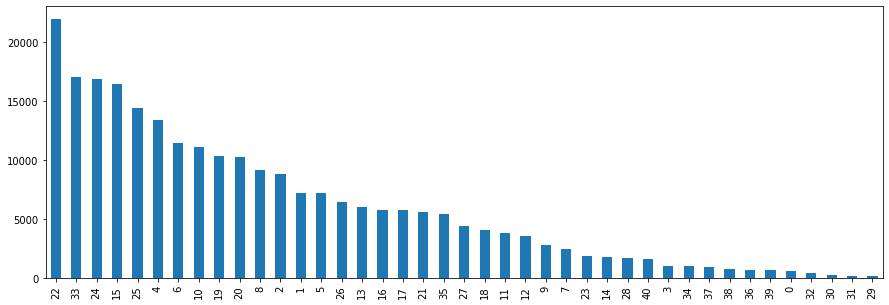

In [22]:
train.label.value_counts().plot(kind='bar',figsize=(15,5))

# Feature Extraction 

## Label-Wise Vocabulary Extraction for % Intersection Features 

In [64]:
def category_wise_vocabulary_extraction(input_df, target='label',
                                        top_words=20):
    vocab_df = pd.DataFrame()

    for tag in input_df[target].unique().tolist():
        temp_df = pd.DataFrame()
        temp_df.loc[0, 'vocab'] = [
            ','.join(
                pd.Series(
                    str(input_df[input_df[target] == tag].text_data.values).
                    split()).value_counts()[:top_words].index.tolist())
        ]
        temp_df.loc[0, 'tag'] = tag
        vocab_df = vocab_df.append(temp_df, ignore_index=True)

    return vocab_df

In [65]:
vocab_df = category_wise_vocabulary_extraction(train.fillna('missing'))

In [107]:
vocab_df[vocab_df.tag==40].vocab.str.split(",").values[0]

['html',
 'zip',
 'text',
 'wikipedia',
 'novel',
 'pgc',
 'epub',
 'story',
 'novelist',
 'texte',
 'science',
 'fiction',
 'canadian',
 'american',
 'english',
 'canada',
 'extension',
 'author',
 'today',
 'first']

In [244]:
Weapons_ = [
    'sword', 'knife', 'gun', 'rifle', 'weapon', 'pistol', 'accessory',
     'ammo', 'air', 'shotgun', 'blade', 'medieval',
    'firearm', 'part', 'steel', 'stock'
]
Travel_ = [
    'training', 'service', 'dealer', 'lakh', 'train', 'expert', 'cottage',
    'quote', 'repair', 'rent', 'consultant', 'house', 'coach',
    'home', 'oyster', 'lake', 'villa', 'station'
]
Transportation_ = [
    'trailer', 'compare', 'list', 'engine', 'boat',
    'include', 'rental', 'airport', 'car', 'length', 'range', 'civic', 'load',
    'forum', 'rite', 'power', 'aluminum'
]
Translators_ = [
    'translation', 'language', 'global', 'localization', 'interpretation',
    'quality', 'ulatus', 'transcription', 'client',
    'international', 'provide', 'project', 'legal', 'document', 'translator',
    'world', 'professional']
Sports_ = [
    'tour', 'golf', 'sunshine', 'virtual', 'tournament', 'sport', 'player',
    'golfrsa', 'final', 'club', 'major', 'south', 'first', 'play', 'challenge',
    'world', 'game', 'regulation', 'pga', 'website'
]
Shopping_ = [
    'table', 'din', 'set', 'cart', 'furniture', 'shoe', 'gift', 'view', 'add',
    'card', 'quick', 'browse', 'base', 'chair', 'sofa', 'top', 'sale', 'bar',
    'outdoor', 'shop'
]
Restaurants_Dining_ = [
    'food', 'cheese', 'west', 'park', 'centre', 'post', 'branch',
    'range', 'green', 'hill', 'white', 'south', 'north', 'fish', 'oil',
    'pantry', 'east', 'red', 'wine'
]
Religion_ = [
    'wicca', 'wiccan', 'witchcraft', 'witch', 'religion', 'isbn', 'church',
    'white', 'pearson', 'tradition', 'doyle', 'gardner', 'god', 'ritual',
    'goddess', 'book', 'magic', 'coven', 'modern', 'pagan'
]
Real_Estate_ = [
    'property', 'solution', 'rural', 'noise', 'village', 'estate', 'info',
    'lifestyle', 'search', 'real', 'offer', 'manor', 'builder', 'land',
    'retirement', 'residential', 'buyer', 'lake',  'tool'
]
Pornography_Sexually_ = [
    'playlist',  'mom', 'hour', 'mature', 'young', 'sex', 'porn', 'big',
    'fuck', 'old', 'milf', 'video', 'teen', 'indian', 'xxx', 'blonde', 'tube',
    'son', 'blowjob'
]
Politics_ = [
    'law', 'criminal', 'attorney', 'lawyer', 'duo', 'tulsa', 'city', 'firm',
    'legal', 'defense', 'citizen', 'client', 'right', 'crime', 'case',
    'design', 'experience', 'family', 'matter', 'divorce'
]
NGOs_ = [
    'child', 'aawc', 'ashlee', 'woman', 'food', 'program', 'zambia',
    'community', 'toy', 'award', 'support', 'hunger', 'volunteer', 'aap',
    'people', 'apne', 'event', 'india', 'give', 'collective'
]
News_ = [
    'student', 'buffalo', 'post', 'academic', 'school', 'world', 'program',
    'resource', 'plan', 'http', 'bill', 'enspadvising', 'wildlife', 'saudi',
    'label', 'fall', 'job', 'police', 'opportunity', 'story'
]
Job_Search_ = [
    'job', 'personal', 'american', 'website', 'application', 'privacy',
    'cooky', 'policy', 'provide', 'process', 'law', 'include', 'kent',
    'request', 'career', 'employment', 'right', 'data', 'kutumbh', 'resource'
]
Information_Security_ = [
    'antivirus', 'feature', 'protection', 'visit', 'program', 'website',
    'review', 'ransomware', 'security', 'like', 'device', 'malware', 'scan',
    'user', 'window', 'file', 'include', 'plan', 'software', 'premium'
]
Health_Medicine_ = [
    'thyroid', 'care', 'read', 'spine', 'patient', 'dbt', 'surgery', 'diet',
    'hypothyroidism', 'hashimoto', 'comment', 'service', 'website', 'home',
    'experience', 'health', 'treatment', 'eye', 'surgical', 'like'
]
Government_ = [
    'veteran', 'service', 'benefit', 'innocence', 'project', 'hon', 'ble',
    'member', 'california', 'law', 'rao', 'sri', 'chief', 'minister', 'free',
    'ncba', 'chandrashekar', 'state', 'policy', 'resource'
]
Games_ = [
    'game', 'event', 'order', 'war', 'pre', 'set', 'pro', 'dice', 'sleeve',
    'post', 'card', 'read', 'seal', 'ultra', 'magic', 'sleepy', 'battlefront',
    'box',  'pokemon'
]
Gambling_ = [
    'match', 'soccer', 'tip', 'pick', 'fix', 'free', 'football', 'bet',
    'prediction', 'play', 'sport', 'poker', 'game', 'fixed', 'money', 'site',
    'today', 'live', 'odd', 'draw'
]
Finance_ = [
    'service', 'tax', 'refund',  'partner', 'plan', 'lga', 'learn',
    'company', 'customer', 'management', 'health', 'ecommerce', 'state',
    'contact', 'road', 'name', 'insurance', 'account'
]
Fashion_Beauty_ = [
    'powder', 'dip', 'nail', 'gel', 'polish', 'data', 'wishlist', 'essential',
    'lacquer', 'add', 'acrylic', 'personal', 'kiara', 'sky', 'browse',
    'liquid', 'wax', 'base', 'cooky', 'woman'
]
Entertainment_ = [
    'disney', 'park', 'world', 'draw', 'cartoon', 'hour', 'hotel', 'walt',
    'shop', 'resort', 'animal', 'search', 'experience', 'press', 'magic',
    'event', 'snowboard', 'ticket', 'surfboard', 'kingdom'
]
Education_ = [
    'tutor', 'fernando', 'grade', 'wishlist', 'book', 'add', 'exam', 'english',
    'browse', 'invasive', 'medium', 'specie', 'support', 'sinhala',
    'level',  'ict', 'technical', 'wildlife'
]
Dating_Matrimonial_ = [
    'date', 'event', 'daters', 'quote', 'men', 'like', 'find', 'age',
    'relationship', 'user', 'mate', 'love', 'matchmaking', 'woman', 'night',
    'speed', 'want', 'meet', 'feel', 'thing'
]
Consumer_Electronics_ = [
    'key', 'call', 'message', 'secure', 'signature', 'protocol', 'like',
    'card', 'element', 'hardware', 'attack', 'store', 'solution',
    'pgp', 'user', 'security', 'encrypt', 'example', 'see'
]
Business_ = [
    'network', 'digital', 'supply', 'trial', 'patient', 'chain', 'healthcare',
    'medical', 'management', 'clinical', 'learn', 'read', 'industry',
    'solution', 'site', 'icon', 'development', 'website', 'web', 'technology'
]
Arts_ = [
    'gift', 'pvblic', 'trust', 'midi', 'charitable', 'tattoo', 'outright',
    'theatre', 'style', 'live', 'single', 'design', 'alabama', 'shadow',
    'image', 'birmingham', 'security', 'award', 'ticket', 'fund'
]
Alcohol_Tobacco_ = [
    'touch', 'vodka', 'part', 'add', 'red', 'wine', 'fry', 'juice', 'cheese',
    'salad', 'lime', 'orange', 'grapefruit', 'vape', 'beef', 'pinot', 'burger',
    'nicotine', 'sauce', 'steak'
]
Storage_ = [
    'data', 'cloud', 'center', 'solution', 'security', 'network',
    'infrastructure', 'learn', 'technology', 'storage', 'sbr', 'manage',
    'desktop', 'company', 'enterprise', 'virtual', 'oneneck', 'compute',
    'blog', 'team'
]
Advertisements_and_Pop_Ups_ = [
    'affiliate', 'publisher', 'program', 'advertising', 'service', 'ad',
    'advertiser', 'site', 'marketing', 'network', 'medium', 'traffic',
    'business', 'campaign', 'content', 'user', 'mobile', 'product', 'book',
    'solution'
]
Web_based_Email_ = [
    'email', 'service', 'mail', 'free', 'account', 'send', 'address', 'server',
    'domain', 'support', 'marketing', 'host', 'business', 'feature', 'cloud',
    'customer', 'solution', 'list', 'data', 'start'
]
Social_Networking_ = [
    'chat', 'instagram', 'facebook', 'like', 'video', 'people', 'site', 'free',
    'post', 'friend', 'user', 'account', 'gmt', 'service', 'page', 'profile',
    'social', 'date', 'share', 'room'
]
Search_Engines_and_Portals_ = [
    'directory', 'business', 'service', 'list', 'home', 'web', 'free',
    'company', 'site', 'computer', 'http', 'art', 'www', 'health', 'category',
    'internet', 'game', 'sport', 'product', 'education'
]
Personal_Sites_ = [
    'blog','post'
]
Online_marketing_ = [
    'marketing', 'business', 'website', 'seo', 'service', 'content',
    'customer', 'social', 'digital', 'free', 'search', 'email', 'medium',
    'site', 'page', 'product', 'tool', 'time', 'blog', 'video'
]
Leisure_and_Recreation_ = [
    'late', 'girl', 'herdy', 'tramp', 'shop', 'world', 'photo', 'video',
    'track', 'scout', 'post', 'tiny', 'walk', 'good', 'island', 'gold',
    'forum', 'lea', 'contact', 'request'
]
Humor_ = [
    'post', 'like', 'people', 'funny', 'time', 'read', 'video', 'comment',
    'joke', 'view', 'see', 'life', 'take', 'find', 'add', 'share', 'world',
    'thing', 'show', 'think'
]
Forums_and_Newsgroups_ = [
    'time', 'like', 'take', 'people', 'post', 'think', 'thing', 'see', 'life',
    'want', 'well', 'go', 'find', 'good', 'first', 'comment', 'love', 'read',
    'really', 'start'
]
File_hosting_ = [
    'download', 'file', 'link', 'free', 'share', 'test', 'apk', 'movie',
    'site', 'game', 'account', 'video', 'torrent', 'mod', 'net', 'post',
    'premium', 'android', 'unlimited', 'state'
]
Childcare_ = [
    'baby', 'shop', 'toy', 'product', 'view', 'accessory', 'add', 'gift',
    'kid', 'bag', 'seat', 'cart', 'set', 'car', 'party', 'price', 'sale',
    'review', 'stroller', 'child'
]
Books_or_comics_ = [
    'html', 'zip', 'text', 'wikipedia', 'novel', 'pgc', 'epub', 'story',
    'novelist', 'texte', 'science', 'fiction', 'canadian', 'american',
    'english', 'canada', 'extension', 'author', 'today', 'first'
]

## Uni-Gram Based Features Extraction 

### Unique Business || Finance & Vice-Versa

In [119]:
unique_business_not_in_finance = extract_top_n_non_common_uni_gram_words(
    train.fillna('missing'), set_a_tag=25, set_b_tag=19, top_n=20)

In [245]:
unique_business_not_in_finance = [
    'contact', 'find', 'sign', 'management', 'marketing', 'order', 'product',
    'system', 'industry', 'post', 'sale', 'solution', 'support', 'customer',
    'website', 'design'
]

In [121]:
unique_finance_not_in_business = extract_top_n_non_common_uni_gram_words(
    train.fillna('missing'), set_a_tag=19, set_b_tag=25, top_n=20)

In [246]:
unique_finance_not_in_business = [
    'fund', 'market', 'home', 'loan', 'financial', 'account', 'term', 'card',
    'payment', 'investment', 'tax', 'rate', 'bank', 'insurance', 'credit',
    'policy'
]

### Unique Education || Business & Vice-Versa

In [123]:
unique_business_not_in_education = extract_top_n_non_common_uni_gram_words(
    train.fillna('missing'), set_a_tag=25, set_b_tag=22, top_n=20)

In [247]:
unique_business_not_in_education = [
    'contact', 'business', 'sign', 'management', 'customer', 'marketing',
    'order', 'product', 'system', 'industry', 'sale', 'solution', 'company',
    'website', 'design'
]

In [125]:
unique_education_not_in_business = extract_top_n_non_common_uni_gram_words(
    train.fillna('missing'), set_a_tag=22, set_b_tag=25, top_n=20)

In [248]:
unique_education_not_in_business = [
    'education', 'program', 'study', 'school', 'research', 'read', 'event',
    'technology', 'science', 'book', 'student', 'course', 'resource',
    'university', 'college'
]

### Unique Porn || Dating & Vice-Versa

In [127]:
unique_porn_not_in_dating = extract_top_n_non_common_uni_gram_words(
    train.fillna('missing'), set_a_tag=9, set_b_tag=23, top_n=20)

In [249]:
unique_porn_not_in_dating = [
    'video', 'tit', 'girl', 'movie', 'anal', 'gay', 'porn', 'sex', 'fuck',
    'big', 'teen', 'cock', 'hot', 'mature', 'asian', 'view', 'pussy', 'tube'
]

In [129]:
unique_dating_not_in_porn = extract_top_n_non_common_uni_gram_words(
    train.fillna('missing'), set_a_tag=23, set_b_tag=9, top_n=20)

In [250]:
unique_dating_not_in_porn = [
    'find', 'life', 'single', 'love', 'relationship', 'member', 'sign',
    'profile', 'like', 'men', 'date', 'shop', 'search', 'string', 'meet',
    'want', 'woman', 'people'
]

### unique Govt. || Business & Vice-Versa

In [131]:
unique_business_not_in_govt = extract_top_n_non_common_uni_gram_words(
    train.fillna('missing'), set_a_tag=25, set_b_tag=16, top_n=20)

In [251]:
unique_business_not_in_govt = [
    'contact', 'business', 'find', 'sign', 'management', 'customer',
    'marketing', 'learn', 'order', 'product', 'system', 'industry', 'sale',
    'solution', 'support', 'company', 'website', 'design'
]

In [133]:
unique_govt_not_in_business = extract_top_n_non_common_uni_gram_words(
    train.fillna('missing'), set_a_tag=16, set_b_tag=25, top_n=20)

In [252]:
unique_govt_not_in_business = [
    'right', 'program', 'national', 'court', 'list', 'public', 'date',
    'office', 'legal', 'visa', 'government', 'search', 'state', 'policy',
    'form', 'department', 'report', 'law'
]

### Feature Uni-Gram 

In [135]:
def uni_gram_word_count(input_df, column='text_data'):
    feature_df = pd.DataFrame()
    feature_df['unique_business_not_in_finance'] = input_df[
        column].swifter.set_npartitions(8).apply(lambda x: count_word_presence(
            str(x).lower(), unique_business_not_in_finance))
    feature_df['unique_finance_not_in_business'] = input_df[
        column].swifter.set_npartitions(8).apply(lambda x: count_word_presence(
            str(x).lower(), unique_finance_not_in_business))
    feature_df['unique_business_not_in_education'] = input_df[
        column].swifter.set_npartitions(8).apply(lambda x: count_word_presence(
            str(x).lower(), unique_business_not_in_education))
    feature_df['unique_education_not_in_business'] = input_df[
        column].swifter.set_npartitions(8).apply(lambda x: count_word_presence(
            str(x).lower(), unique_education_not_in_business))
    feature_df['unique_porn_not_in_dating'] = input_df[
        column].swifter.set_npartitions(8).apply(lambda x: count_word_presence(
            str(x).lower(), unique_porn_not_in_dating))
    feature_df['unique_dating_not_in_porn'] = input_df[
        column].swifter.set_npartitions(8).apply(lambda x: count_word_presence(
            str(x).lower(), unique_dating_not_in_porn))

    feature_df['unique_business_not_in_govt'] = input_df[
        column].swifter.set_npartitions(8).apply(lambda x: count_word_presence(
            str(x).lower(), unique_business_not_in_govt))
    feature_df['unique_govt_not_in_business'] = input_df[
        column].swifter.set_npartitions(8).apply(lambda x: count_word_presence(
            str(x).lower(), unique_govt_not_in_business))
    return feature_df

## Feature Set-I Extraction 

In [136]:
features_train = pd.DataFrame()

In [141]:
vectorizer = TfidfVectorizer(max_features=2000,
                             min_df=10,
                             stop_words='english')
vectorizer.fit(train['text_data'].fillna('missing'))

tfidf_vect_ngram = TfidfVectorizer(analyzer='word',
                                   token_pattern=r'\w{1,}',
                                   ngram_range=(1, 3),
                                   max_features=500)
tfidf_vect_ngram.fit(train['pre_processed_url'].fillna('missing'))

TfidfVectorizer(max_features=500, ngram_range=(1, 3), token_pattern='\\w{1,}')

In [143]:
X = vectorizer.transform(train['text_data'].fillna('missing'))
X_url = tfidf_vect_ngram.transform(train['pre_processed_url'].fillna('missing'))

In [144]:
features_text = pd.DataFrame(
    data=X.toarray(),
    columns=['tfidf_content_' + str(i) for i in range(X.shape[1])])
print(features_text.shape)

features_url = pd.DataFrame(
    data=X_url.toarray(),
    columns=['tfidf_url_' + str(i) for i in range(X_url.shape[1])])
print(features_url.shape)

(245157, 2000)
(245157, 500)


In [145]:
features_train = pd.concat([features_text, features_url],
                     axis=1,
                     ignore_index=False,
                     copy=True)
print(features_train.shape)
features_train.head()

(245157, 2500)


,tfidf_content_0,tfidf_content_1,tfidf_content_2,tfidf_content_3,tfidf_content_4,tfidf_content_5,tfidf_content_6,tfidf_content_7,tfidf_content_8,tfidf_content_9,tfidf_content_10,tfidf_content_11,tfidf_content_12,tfidf_content_13,tfidf_content_14,tfidf_content_15,tfidf_content_16,tfidf_content_17,tfidf_content_18,tfidf_content_19,tfidf_content_20,tfidf_content_21,tfidf_content_22,tfidf_content_23,tfidf_content_24,tfidf_content_25,tfidf_content_26,tfidf_content_27,tfidf_content_28,tfidf_content_29,tfidf_content_30,tfidf_content_31,tfidf_content_32,tfidf_content_33,tfidf_content_34,tfidf_content_35,tfidf_content_36,tfidf_content_37,tfidf_content_38,tfidf_content_39,tfidf_content_40,tfidf_content_41,tfidf_content_42,tfidf_content_43,tfidf_content_44,tfidf_content_45,tfidf_content_46,tfidf_content_47,tfidf_content_48,tfidf_content_49,tfidf_content_50,tfidf_content_51,tfidf_content_52,tfidf_content_53,tfidf_content_54,tfidf_content_55,tfidf_content_56,tfidf_content_57,tfidf_content_58,tfidf_content_59,tfidf_content_60,tfidf_content_61,tfidf_content_62,tfidf_content_63,tfidf_content_64,tfidf_content_65,tfidf_content_66,tfidf_content_67,tfidf_content_68,tfidf_content_69,tfidf_content_70,tfidf_content_71,tfidf_content_72,tfidf_content_73,tfidf_content_74,tfidf_content_75,tfidf_content_76,tfidf_content_77,tfidf_content_78,tfidf_content_79,tfidf_content_80,tfidf_content_81,tfidf_content_82,tfidf_content_83,tfidf_content_84,tfidf_content_85,tfidf_content_86,tfidf_content_87,tfidf_content_88,tfidf_content_89,tfidf_content_90,tfidf_content_91,tfidf_content_92,tfidf_content_93,tfidf_content_94,tfidf_content_95,tfidf_content_96,tfidf_content_97,tfidf_content_98,tfidf_content_99,tfidf_content_100,tfidf_content_101,tfidf_content_102,tfidf_content_103,tfidf_content_104,tfidf_content_105,tfidf_content_106,tfidf_content_107,tfidf_content_108,tfidf_content_109,tfidf_content_110,tfidf_content_111,tfidf_content_112,tfidf_content_113,tfidf_content_114,tfidf_content_115,tfidf_content_116,tfidf_content_117,tfidf_content_118,tfidf_content_119,tfidf_content_120,tfidf_content_121,tfidf_content_122,tfidf_content_123,tfidf_content_124,tfidf_content_125,tfidf_content_126,tfidf_content_127,tfidf_content_128,tfidf_content_129,tfidf_content_130,tfidf_content_131,tfidf_content_132,tfidf_content_133,tfidf_content_134,tfidf_content_135,tfidf_content_136,tfidf_content_137,tfidf_content_138,tfidf_content_139,tfidf_content_140,tfidf_content_141,tfidf_content_142,tfidf_content_143,tfidf_content_144,tfidf_content_145,tfidf_content_146,tfidf_content_147,tfidf_content_148,tfidf_content_149,tfidf_content_150,tfidf_content_151,tfidf_content_152,tfidf_content_153,tfidf_content_154,tfidf_content_155,tfidf_content_156,tfidf_content_157,tfidf_content_158,tfidf_content_159,tfidf_content_160,tfidf_content_161,tfidf_content_162,tfidf_content_163,tfidf_content_164,tfidf_content_165,tfidf_content_166,tfidf_content_167,tfidf_content_168,tfidf_content_169,tfidf_content_170,tfidf_content_171,tfidf_content_172,tfidf_content_173,tfidf_content_174,tfidf_content_175,tfidf_content_176,tfidf_content_177,tfidf_content_178,tfidf_content_179,tfidf_content_180,tfidf_content_181,tfidf_content_182,tfidf_content_183,tfidf_content_184,tfidf_content_185,tfidf_content_186,tfidf_content_187,tfidf_content_188,tfidf_content_189,tfidf_content_190,tfidf_content_191,tfidf_content_192,tfidf_content_193,tfidf_content_194,tfidf_content_195,tfidf_content_196,tfidf_content_197,tfidf_content_198,tfidf_content_199,tfidf_content_200,tfidf_content_201,tfidf_content_202,tfidf_content_203,tfidf_content_204,tfidf_content_205,tfidf_content_206,tfidf_content_207,tfidf_content_208,tfidf_content_209,tfidf_content_210,tfidf_content_211,tfidf_content_212,tfidf_content_213,tfidf_content_214,tfidf_content_215,tfidf_content_216,tfidf_content_217,tfidf_content_218,tfidf_content_219,tfidf_content_220,tfidf_content_221,tfidf_content_222,tfidf_content_223,tfidf_content_224,tfidf_content_225,tfidf_content_226,tfidf_content_227,tfidf

In [146]:
del features_text,features_url,X, X_url

### Dump TF-IDF

In [147]:
pickle.dump(
    vectorizer,
    open("/root/URL_CAT/URL_Categorization_V2.0/Model_Dumpyard/tfidf_vectorizer_28Oct2020.pickle",
         "wb"))

pickle.dump(
    tfidf_vect_ngram,
    open("/root/URL_CAT/URL_Categorization_V2.0/Model_Dumpyard/tfidf_vect_ngram_28Oct2020.pickle",
         "wb"))


## Feature Set-II Extraction 

In [165]:
word_pos_feature_df = parallelize_dataframe(train.fillna('missing'),
                                            word_pos_feature)
print(word_pos_feature_df.shape)
word_pos_feature_df.head()


(245157, 10)


,noun_count,verb_count,adj_count,adv_count,pron_count,noun_count_url,verb_count_url,adj_count_url,adv_count_url,pron_count_url
0,347,40,84,7,0,2,0,0,0,0
1,4019,695,1477,313,7,1,0,1,0,0
2,974,108,263,20,5,2,0,0,0,0
3,253,15,50,2,0,2,0,0,0,0
4,169,16,64,2,0,3,0,0,0,0


In [166]:
word_pos_feature_df.to_csv("word_pos_feature_28Oct2020.csv",index=False)

In [167]:
check_count_df = parallelize_dataframe(train.fillna('missing'), check_count)
print(check_count_df.shape)
check_count_df.head()


(245157, 10)


,Shop,news,information_security,games,entertainment,education,business,arts,dating_count,weapons_count
0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [170]:
add_static_url_features_df = parallelize_dataframe(train.fillna('missing'),
                                                   add_static_url_features)
print(add_static_url_features_df.shape)
add_static_url_features_df.head()



(245157, 20)


,url_length,is_IP_address,length_of_query_string_in_URL,token_count,no_of_dots,no_of_hyphen,no_of_underscore,no_of_equal,no_of_forward_slash,no_of_question_marks,no_of_semicolon,no_of_open_parenthesis,no_of_mod,no_of_ampersand,no_of_@,no_of_double_slash,no_of_digits,url_entropy,non_www_url,domain_has_ip_addr
0,14,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,3.378783,0,0
1,15,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,3.506891,0,0
2,14,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,3.521641,0,0
3,10,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,2.921928,0,0
4,15,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,3.640224,0,0


In [174]:
extract_density_based_features_df = parallelize_dataframe(
    train.fillna('missing'), extract_density_based_features)
print(extract_density_based_features_df.shape)
extract_density_based_features_df.head()








(245157, 10)


,char_count,content_word_count,word_density,avg_word_length,noun_density,verb_density,adj_density,adv_density,pron_density,avg_pos_density
0,3556,550,6.453721,0.154625,0.629764,0.072595,0.152450,0.012704,0.000000,0.173503
1,49026,6855,7.150817,0.139821,0.586202,0.101371,0.215432,0.045653,0.001021,0.189936
2,10535,1451,7.255510,0.137718,0.670799,0.074380,0.181129,0.013774,0.003444,0.188705
3,2277,323,7.027778,0.141791,0.780864,0.046296,0.154321,0.006173,0.000000,0.197531
4,1800,254,7.058824,0.141033,0.662745,0.062745,0.250980,0.007843,0.000000,0.196863


In [175]:
extract_density_based_features_df.to_csv("extract_density_based_features_28Oct2020.csv",index=False)

In [171]:
percentage_word_based_features_df = parallelize_dataframe(
    train.fillna('missing'), percentage_word_based_features)
print(percentage_word_based_features_df.shape)
percentage_word_based_features_df.head()







(245157, 41)


,%_intersection_with_Weapons_,%_intersection_with_Travel_,%_intersection_with_Transportation_,%_intersection_with_Translators_,%_intersection_with_Sports_,%_intersection_with_Shopping_,%_intersection_with_Restaurants_Dining_,%_intersection_with_Religion_,%_intersection_with_Real_Estate_,%_intersection_with_Pornography_Sexually_,%_intersection_with_Politics_,%_intersection_with_NGOs_,%_intersection_with_News_,%_intersection_with_Job_Search_,%_intersection_with_Information_Security_,%_intersection_with_Health_Medicine_,%_intersection_with_Government_,%_intersection_with_Games_,%_intersection_with_Gambling_,%_intersection_with_Finance_,%_intersection_with_Fashion_Beauty_,%_intersection_with_Entertainment_,%_intersection_with_Education_,%_intersection_with_Dating_Matrimonial_,%_intersection_with_Consumer_Electronics_,%_intersection_with_Business_,%_intersection_with_Arts_,%_intersection_with_Alcohol_Tobacco_,%_intersection_with_Storage_,%_intersection_with_Advertisements_and_Pop_Ups_,%_intersection_with_Web_based_Email_,%_intersection_with_Social_Networking_,%_intersection_with_Search_Engines_and_Portals_,%_intersection_with_Personal_Sites_,%_intersection_with_Online_marketing_,%_intersection_with_Leisure_and_Recreation_,%_intersection_with_Humor_,%_intersection_with_Forums_and_Newsgroups_,%_intersection_with_File_hosting_,%_intersection_with_Childcare_,%_intersection_with_Books_or_comics_
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.00,0.0,0.047619,0.0,0.0,0.047619,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.05,0.000000,0.0,0.0,0.000000,0.000000,0.047619,0.000000,0.000000,0.0,0.047619,0.000000,0.000000,0.000000,0.047619,0.047619,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.047619,0.00,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.047619,0.047619,0.0,0.05,0.0,0.0,0.0,0.0,0.000000,0.047619,0.50,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.047619,0.000000,0.0,0.000000,0.000000,0.047619,0.047619,0.000000,0.000000,0.000000
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.05,0.05,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.10,0.095238,0.0,0.0,0.095238,0.047619,0.095238,0.047619,0.047619,0.0,0.047619,0.047619,0.047619,0.000000,0.047619,0.000000,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.05,0.0,0.00,0.00,0.0,0.047619,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.058824,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.052632,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.047619


In [172]:
image_gif_based_features_df = parallelize_dataframe(train.fillna('missing'),
                                                    image_gif_based_features)
print(image_gif_based_features_df.shape)
image_gif_based_features_df.head()





(245157, 9)


,image_count,gif_count,ratio_image_word,ratio_gif_word,ratio_gif_image,video_count,ratio_video_word,ratio_gif_video,ratio_video_image
0,1,0,0.001815,0.0,0.0,0,0.0,0.0,0.0
1,0,0,0.000000,0.0,0.0,0,0.0,0.0,0.0
2,0,0,0.000000,0.0,0.0,0,0.0,0.0,0.0
3,0,0,0.000000,0.0,0.0,0,0.0,0.0,0.0
4,0,0,0.000000,0.0,0.0,0,0.0,0.0,0.0


In [173]:
uni_gram_word_count_df = parallelize_dataframe(train.fillna('missing'),
                                               uni_gram_word_count)
print(uni_gram_word_count_df.shape)
uni_gram_word_count_df.head()









(245157, 8)


,unique_business_not_in_finance,unique_finance_not_in_business,unique_business_not_in_education,unique_education_not_in_business,unique_porn_not_in_dating,unique_dating_not_in_porn,unique_business_not_in_govt,unique_govt_not_in_business
0,14,11,11,1,5,14,16,6
1,161,100,107,36,13,140,145,76
2,64,12,72,19,24,12,76,10
3,3,0,3,1,0,1,3,2
4,13,5,10,1,3,5,13,4


## Concat All Features 

In [176]:
features_train_df = pd.DataFrame()

In [177]:
columns_ = features_train.columns.tolist()
columns_.extend(word_pos_feature_df.columns.tolist())
columns_.extend(check_count_df.columns.tolist())
columns_.extend(add_static_url_features_df.columns.tolist())
columns_.extend(extract_density_based_features_df.columns.tolist())
columns_.extend(percentage_word_based_features_df.columns.tolist())
columns_.extend(image_gif_based_features_df.columns.tolist())
columns_.extend(uni_gram_word_count_df.columns.tolist())

In [179]:
f = np.concatenate(
    (np.array(features_train), np.array(word_pos_feature_df),
     np.array(check_count_df), np.array(add_static_url_features_df),
    np.array(extract_density_based_features_df),
    np.array(percentage_word_based_features_df),
    np.array(image_gif_based_features_df),
    np.array(uni_gram_word_count_df)),
    axis=1)

features_train_df = pd.DataFrame(f)
features_train_df.columns = columns_
print(features_train_df.shape)
features_train_df.sample(5)

(245157, 2608)


,tfidf_content_0,tfidf_content_1,tfidf_content_2,tfidf_content_3,tfidf_content_4,tfidf_content_5,tfidf_content_6,tfidf_content_7,tfidf_content_8,tfidf_content_9,tfidf_content_10,tfidf_content_11,tfidf_content_12,tfidf_content_13,tfidf_content_14,tfidf_content_15,tfidf_content_16,tfidf_content_17,tfidf_content_18,tfidf_content_19,tfidf_content_20,tfidf_content_21,tfidf_content_22,tfidf_content_23,tfidf_content_24,tfidf_content_25,tfidf_content_26,tfidf_content_27,tfidf_content_28,tfidf_content_29,tfidf_content_30,tfidf_content_31,tfidf_content_32,tfidf_content_33,tfidf_content_34,tfidf_content_35,tfidf_content_36,tfidf_content_37,tfidf_content_38,tfidf_content_39,tfidf_content_40,tfidf_content_41,tfidf_content_42,tfidf_content_43,tfidf_content_44,tfidf_content_45,tfidf_content_46,tfidf_content_47,tfidf_content_48,tfidf_content_49,tfidf_content_50,tfidf_content_51,tfidf_content_52,tfidf_content_53,tfidf_content_54,tfidf_content_55,tfidf_content_56,tfidf_content_57,tfidf_content_58,tfidf_content_59,tfidf_content_60,tfidf_content_61,tfidf_content_62,tfidf_content_63,tfidf_content_64,tfidf_content_65,tfidf_content_66,tfidf_content_67,tfidf_content_68,tfidf_content_69,tfidf_content_70,tfidf_content_71,tfidf_content_72,tfidf_content_73,tfidf_content_74,tfidf_content_75,tfidf_content_76,tfidf_content_77,tfidf_content_78,tfidf_content_79,tfidf_content_80,tfidf_content_81,tfidf_content_82,tfidf_content_83,tfidf_content_84,tfidf_content_85,tfidf_content_86,tfidf_content_87,tfidf_content_88,tfidf_content_89,tfidf_content_90,tfidf_content_91,tfidf_content_92,tfidf_content_93,tfidf_content_94,tfidf_content_95,tfidf_content_96,tfidf_content_97,tfidf_content_98,tfidf_content_99,tfidf_content_100,tfidf_content_101,tfidf_content_102,tfidf_content_103,tfidf_content_104,tfidf_content_105,tfidf_content_106,tfidf_content_107,tfidf_content_108,tfidf_content_109,tfidf_content_110,tfidf_content_111,tfidf_content_112,tfidf_content_113,tfidf_content_114,tfidf_content_115,tfidf_content_116,tfidf_content_117,tfidf_content_118,tfidf_content_119,tfidf_content_120,tfidf_content_121,tfidf_content_122,tfidf_content_123,tfidf_content_124,tfidf_content_125,tfidf_content_126,tfidf_content_127,tfidf_content_128,tfidf_content_129,tfidf_content_130,tfidf_content_131,tfidf_content_132,tfidf_content_133,tfidf_content_134,tfidf_content_135,tfidf_content_136,tfidf_content_137,tfidf_content_138,tfidf_content_139,tfidf_content_140,tfidf_content_141,tfidf_content_142,tfidf_content_143,tfidf_content_144,tfidf_content_145,tfidf_content_146,tfidf_content_147,tfidf_content_148,tfidf_content_149,tfidf_content_150,tfidf_content_151,tfidf_content_152,tfidf_content_153,tfidf_content_154,tfidf_content_155,tfidf_content_156,tfidf_content_157,tfidf_content_158,tfidf_content_159,tfidf_content_160,tfidf_content_161,tfidf_content_162,tfidf_content_163,tfidf_content_164,tfidf_content_165,tfidf_content_166,tfidf_content_167,tfidf_content_168,tfidf_content_169,tfidf_content_170,tfidf_content_171,tfidf_content_172,tfidf_content_173,tfidf_content_174,tfidf_content_175,tfidf_content_176,tfidf_content_177,tfidf_content_178,tfidf_content_179,tfidf_content_180,tfidf_content_181,tfidf_content_182,tfidf_content_183,tfidf_content_184,tfidf_content_185,tfidf_content_186,tfidf_content_187,tfidf_content_188,tfidf_content_189,tfidf_content_190,tfidf_content_191,tfidf_content_192,tfidf_content_193,tfidf_content_194,tfidf_content_195,tfidf_content_196,tfidf_content_197,tfidf_content_198,tfidf_content_199,tfidf_content_200,tfidf_content_201,tfidf_content_202,tfidf_content_203,tfidf_content_204,tfidf_content_205,tfidf_content_206,tfidf_content_207,tfidf_content_208,tfidf_content_209,tfidf_content_210,tfidf_content_211,tfidf_content_212,tfidf_content_213,tfidf_content_214,tfidf_content_215,tfidf_content_216,tfidf_content_217,tfidf_content_218,tfidf_content_219,tfidf_content_220,tfidf_content_221,tfidf_content_222,tfidf_content_223,tfidf_content_224,tfidf_content_225,tfidf_content_226,tfidf_content_227,tfidf

In [180]:
features_train_df.to_csv("all_features_train_29Oct2020.csv",index=False)

In [181]:
del f, features_train, word_pos_feature_df, check_count_df
del add_static_url_features_df, extract_density_based_features_df
del percentage_word_based_features_df,image_gif_based_features_df
del uni_gram_word_count_df

In [183]:
del Weapons_,
Travel_,
Transportation_,
Translators_,
Sports_,
Shopping_,
Restaurants_Dining_,
Religion_,
Real_Estate_,
Pornography_Sexually_,
Politics_,
NGOs_,
News_,
Job_Search_,
Information_Security_,
Health_Medicine_,
Government_,
Games_,
Gambling_,
Finance_,
Fashion_Beauty_,
Entertainment_,
Education_,
Dating_Matrimonial_,
Consumer_Electronics_,
Business_,
Arts_,
Alcohol_Tobacco_,
Storage_,
Advertisements_and_Pop_Ups,
Web_based_Email,
Social_Networking,
Search_Engines_and_Portals,
Personal_Sites,
Online_marketing,
Leisure_and_Recreation,
Humor_,
Forums_and_Newsgroups,
File_hosting_,
Childcare_,
Books_or_comics_

NameError: name 'Weapons_' is not defined

# Feature Selection 

In [185]:
features_train_df['label'] = train.label.copy()

In [187]:
features_train_df = features_train_df[~features_train_df.duplicated()].copy()

In [188]:
features_train_df.shape

(244987, 2609)

In [189]:
features_train_df.describe()

tfidf_content_0  tfidf_content_1  tfidf_content_2  tfidf_content_3  \
count    244987.000000    244987.000000    244987.000000    244987.000000   
mean          0.002171         0.001742         0.003595         0.002718   
std           0.011576         0.016877         0.023526         0.022056   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.000000         0.000000         0.000000         0.000000   
50%           0.000000         0.000000         0.000000         0.000000   
75%           0.000000         0.000000         0.000000         0.000000   
max           0.622637         0.945433         0.834605         0.900321   

       tfidf_content_4  tfidf_content_5  tfidf_content_6  tfidf_content_7  \
count    244987.000000     244987.00000    244987.000000    244987.000000   
mean          0.003685          0.00845         0.002633         0.009604   
std           0.015019          0.02869         0.014477         0.040413   
min           0.000000          0.00000         0.000000         0.000000   
25%           0.000000          0.00000         0.000000         0.000000   
50%           0.000000          0.00000         0.000000         0.000000   
75%           0.000000          0.00000         0.000000         0.000000   
max           0.844892          1.00000         0.912768         0.971175   

       tfidf_content_8  tfidf_content_9  tfidf_content_10  tfidf_content_11  \
count    244987.000000    244987.000000     244987.000000     244987.000000   
mean          0.002792         0.001628          0.011605          0.001531   
std           0.029859         0.015425          0.032778          0.017305   
min           0.000000         0.000000          0.000000          0.000000   
25%           0.000000         0.000000          0.000000          0.000000   
50%           0.000000         0.000000          0.000000          0.000000   
75%           0.000000         0.000000          0.005681          0.000000   
max           0.908280         0.851353          0.965637          0.887119   

       tfidf_content_12  tfidf_content_13  tfidf_content_14  tfidf_content_15  \
count     244987.000000     244987.000000     244987.000000     244987.000000   
mean           0.001449          0.002725          0.003955          0.005088   
std            0.010165          0.012521          0.020080          0.022142   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            0.648575          0.522101          0.899806          0.986846   

       tfidf_content_16  tfidf_content_17  tfidf_content_18  tfidf_content_19  \
count     244987.000000     244987.000000     244987.000000     244987.000000   
mean           0.002777          0.005279          0.002334          0.001392   
std            0.015645          0.022466          0.020632          0.015440   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            0.769059          0.819377          0.929223          0.881746   

       tfidf_content_20  tfidf_content_21  tfidf_content_22  tfidf_content_23  \
count     244987.000000     244987.000000     244987.000000     244987.000000   
mean           0.001026          0.012686          0.001969          0.002558   
std            0.014304          0.048030          0.009843          0.011838   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000 

## Feature Co-relation 

In [190]:
corr_matrix = features_train_df.loc[:, ~features_train_df.columns.isin(['label'])].corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop

['tfidf_content_1004',
 'tfidf_url_43',
 'tfidf_url_48',
 'tfidf_url_57',
 'tfidf_url_68',
 'tfidf_url_81',
 'tfidf_url_98',
 'tfidf_url_121',
 'tfidf_url_172',
 'tfidf_url_175',
 'tfidf_url_181',
 'tfidf_url_205',
 'tfidf_url_220',
 'tfidf_url_228',
 'tfidf_url_278',
 'tfidf_url_309',
 'tfidf_url_324',
 'tfidf_url_327',
 'tfidf_url_340',
 'tfidf_url_370',
 'tfidf_url_373',
 'tfidf_url_374',
 'tfidf_url_375',
 'tfidf_url_376',
 'tfidf_url_377',
 'tfidf_url_407',
 'tfidf_url_414',
 'tfidf_url_438',
 'tfidf_url_440',
 'tfidf_url_446',
 'tfidf_url_450',
 'tfidf_url_452',
 'tfidf_url_453',
 'tfidf_url_459',
 'tfidf_url_461',
 'tfidf_url_467',
 'tfidf_url_475',
 'tfidf_url_478',
 'tfidf_url_479',
 'tfidf_url_480',
 'tfidf_url_481',
 'tfidf_url_485',
 'tfidf_url_491',
 'tfidf_url_498',
 'tfidf_url_499',
 'verb_count',
 'adj_count',
 'char_count',
 'content_word_count',
 'avg_word_length',
 'ratio_gif_video',
 'unique_business_not_in_govt']

In [ ]:
[
    'tfidf_content_1004', 'tfidf_url_43', 'tfidf_url_48', 'tfidf_url_57',
    'tfidf_url_68', 'tfidf_url_81', 'tfidf_url_98', 'tfidf_url_121',
    'tfidf_url_172', 'tfidf_url_175', 'tfidf_url_181', 'tfidf_url_205',
    'tfidf_url_220', 'tfidf_url_228', 'tfidf_url_278', 'tfidf_url_309',
    'tfidf_url_324', 'tfidf_url_327', 'tfidf_url_340', 'tfidf_url_370',
    'tfidf_url_373', 'tfidf_url_374', 'tfidf_url_375', 'tfidf_url_376',
    'tfidf_url_377', 'tfidf_url_407', 'tfidf_url_414', 'tfidf_url_438',
    'tfidf_url_440', 'tfidf_url_446', 'tfidf_url_450', 'tfidf_url_452',
    'tfidf_url_453', 'tfidf_url_459', 'tfidf_url_461', 'tfidf_url_467',
    'tfidf_url_475', 'tfidf_url_478', 'tfidf_url_479', 'tfidf_url_480',
    'tfidf_url_481', 'tfidf_url_485', 'tfidf_url_491', 'tfidf_url_498',
    'tfidf_url_499', 'verb_count', 'adj_count', 'char_count',
    'content_word_count', 'avg_word_length', 'ratio_gif_video',
    'unique_business_not_in_govt'
]

In [192]:
features_train_df.drop(columns=to_drop,inplace=True)

# Model Training : LGBM

In [193]:
def lgbm_model(
        feature,
        target,
        params={
            "objective": "multiclassova",
            "metric": "multi_logloss",
            "num_class": 41,
            "num_leaves": 60,
            "max_depth": -1,
            "learning_rate": 0.01,
            "bagging_fraction": 0.9,
            "feature_fraction": 0.8,
            "bagging_freq": 5,
            "bagging_seed": 2020,
            "verbosity": -1
        },num_boost_round=600):
    X_train, X_valid, y_train, y_valid = train_test_split(feature,
                                                          target,
                                                          test_size=0.2,
                                                          random_state=12345)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    evals_result = {}

    lgbmodel = lgb.train(params,
                         lgb_train,
                         num_boost_round,
                         valid_sets=[lgb_train, lgb_valid],
                         evals_result=evals_result,
                         early_stopping_rounds=100,
                         verbose_eval=100)

    print('Plot metrics during training...')
    ax = lgb.plot_metric(evals_result, metric='multi_logloss', figsize=(10, 5))
    plt.show()
    preds_train = lgbmodel.predict(X_train,
                                   num_iteration=lgbmodel.best_iteration)
    preds_val = lgbmodel.predict(X_valid,
                                 num_iteration=lgbmodel.best_iteration)
    p_train = [np.argmax(line) for line in preds_train]
    p_val = [np.argmax(line) for line in preds_val]
    train_evaluation_df = (
        (evaluate_model(np.array(y_train), p_train)) *
        100).copy()
    validation_evaluation_df = (
        (evaluate_model(np.array(y_valid), p_val)) *
        100).copy()

    return (train_evaluation_df, validation_evaluation_df, lgbmodel)

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.60593	valid_1's multi_logloss: 1.69201
[200]	training's multi_logloss: 1.28877	valid_1's multi_logloss: 1.4143
[300]	training's multi_logloss: 1.13598	valid_1's multi_logloss: 1.29359
[400]	training's multi_logloss: 1.04257	valid_1's multi_logloss: 1.22739
[500]	training's multi_logloss: 0.975949	valid_1's multi_logloss: 1.18456
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.975949	valid_1's multi_logloss: 1.18456
Plot metrics during training...


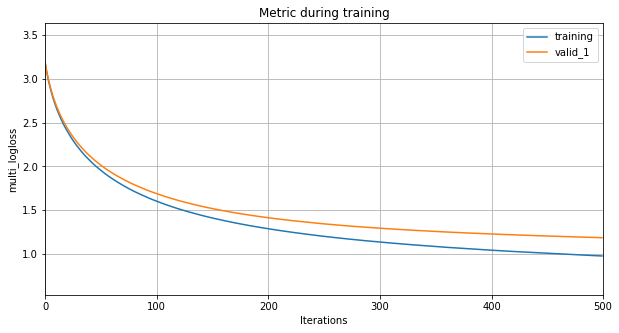

In [200]:
tra, val , lgbm = lgbm_model(features_train_df[features_train_df.columns[:-1]],features_train_df['label'],params={
    "objective": "multiclassova",
    "metric": "multi_logloss",
    "num_class": 41,
    "num_leaves": 60,
    "max_depth": 6,
    "learning_rate": 0.01,
    "bagging_fraction": 0.6,
    "feature_fraction": 0.6,
    "bagging_freq": 5,
    "bagging_seed": 2020,
    "verbosity": -1,
    "reg_alpha": 0.21,
    "reg_lambda": 0.89
},num_boost_round=500) 

In [201]:
tra.sort_index(ascending=False)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,78.7284,78.7284,0.53,21.27,98.96,78.7284
9,94.02,91.53,0.10,5.98,99.83,92.76
8,84.02,88.23,0.44,15.98,98.98,86.08
7,86.58,93.39,0.06,13.42,99.80,89.86
6,82.13,83.56,0.79,17.87,98.42,82.84
5,63.33,77.5,0.55,36.67,98.39,69.71
40,69.61,87.63,0.07,30.39,99.73,77.59
4,82.04,84.6,0.86,17.96,98.21,83.3
39,90.77,90.41,0.03,9.23,99.95,90.59
38,72.2,86.76,0.04,27.80,99.88,78.81


In [203]:
np.round(val.astype('float32')).sort_values(by='F1_Score')

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
36,16.0,71.0,0.0,84.0,100.0,26.0
29,30.0,60.0,0.0,70.0,100.0,40.0
38,29.0,63.0,0.0,71.0,100.0,40.0
34,42.0,54.0,0.0,58.0,100.0,47.0
40,42.0,63.0,0.0,58.0,99.0,50.0
35,42.0,66.0,0.0,58.0,98.0,51.0
31,37.0,95.0,0.0,63.0,100.0,53.0
33,61.0,50.0,4.0,39.0,93.0,55.0
25,60.0,55.0,3.0,40.0,95.0,57.0
26,60.0,60.0,1.0,40.0,98.0,60.0


## Feature Importance 

In [210]:
feature_importance_df = pd.DataFrame({
    'Feature_importance': lgbm.feature_importance(),
    'Feature': lgbm.feature_name()
}).sort_values(by='Feature_importance', ascending=False)

In [242]:
feature_importance_df.to_csv(
    "Feature_Importance_All_Non_Corelated_Features_Train_29Oct2020.csv",
    index=False)

In [236]:
feature_importance_df[feature_importance_df.Feature_importance>258].shape

(720, 2)

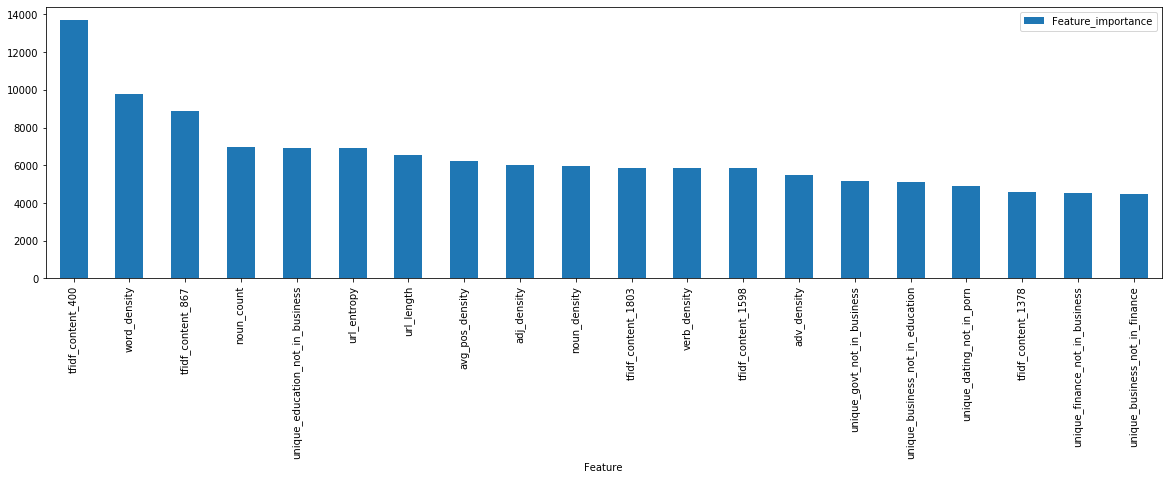

In [212]:
feature_importance_df.iloc[:20].plot(kind='bar',
                                    x='Feature',
                                    y='Feature_importance',
                                    figsize=(20, 5))

## Model with Top-X Features 

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.61591	valid_1's multi_logloss: 1.70629
[200]	training's multi_logloss: 1.30891	valid_1's multi_logloss: 1.44071
[300]	training's multi_logloss: 1.16021	valid_1's multi_logloss: 1.32583
[400]	training's multi_logloss: 1.06862	valid_1's multi_logloss: 1.263
[500]	training's multi_logloss: 1.002	valid_1's multi_logloss: 1.22141
[600]	training's multi_logloss: 0.949455	valid_1's multi_logloss: 1.19209
[700]	training's multi_logloss: 0.905348	valid_1's multi_logloss: 1.16995
[800]	training's multi_logloss: 0.867147	valid_1's multi_logloss: 1.15237
Did not meet early stopping. Best iteration is:
[800]	training's multi_logloss: 0.867147	valid_1's multi_logloss: 1.15237
Plot metrics during training...


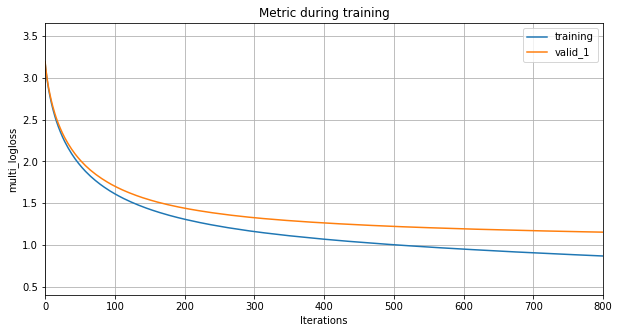

In [237]:
tra, val, lgbm = lgbm_model(features_train_df[feature_importance_df[
    feature_importance_df.Feature_importance > 258]['Feature'].tolist()],
    features_train_df['label'],
    params={
    "objective": "multiclassova",
    "metric": "multi_logloss",
    "num_class": 41,
    "num_leaves": 60,
    "max_depth": 6,
    "learning_rate": 0.01,
    "bagging_fraction": 0.7,
    "feature_fraction": 0.7,
    "bagging_freq": 5,
    "bagging_seed": 2020,
    "verbosity": -1,
    "reg_alpha": 0.21,
    "reg_lambda": 0.89
},
    num_boost_round=800)

In [240]:
tra.sort_index(ascending=False)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,80.3943,80.3943,0.49,19.61,99.04,80.3943
9,95.83,92.44,0.09,4.17,99.86,94.11
8,84.96,86.71,0.51,15.04,98.95,85.83
7,89.42,94.9,0.05,10.58,99.84,92.08
6,83.24,84.24,0.76,16.76,98.49,83.74
5,66.46,80.59,0.48,33.54,98.55,72.85
40,75.59,91.58,0.05,24.41,99.79,82.82
4,83.62,84.16,0.91,16.38,98.25,83.89
39,94.11,94.48,0.01,5.89,99.97,94.29
38,80.67,90.66,0.03,19.33,99.91,85.38


In [243]:
np.round(val.astype('float32')).sort_values(by='F1_Score',ascending=False)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
10,93.0,92.0,0.0,7.0,99.0,93.0
3,90.0,94.0,0.0,10.0,100.0,92.0
9,89.0,91.0,0.0,11.0,100.0,90.0
32,82.0,97.0,0.0,18.0,100.0,89.0
0,81.0,87.0,0.0,19.0,100.0,84.0
27,82.0,86.0,0.0,18.0,99.0,84.0
28,81.0,86.0,0.0,19.0,100.0,83.0
18,80.0,87.0,0.0,20.0,99.0,83.0
7,75.0,91.0,0.0,25.0,100.0,82.0
4,80.0,79.0,1.0,20.0,98.0,80.0


# Model Hyper-Parameter Tunning

# Model Evaluation 

## Ready Test Features 

In [258]:
test = pd.read_csv(
    "/root/URL_CAT/URL_Categorization_V2.0/Pre_Processed_Data/test_pre_processed_28Oct2020.csv"
)

In [259]:
features_test = pd.DataFrame()
X_test = vectorizer.transform(test['text_data'])
X_test_url = tfidf_vect_ngram.transform(test['pre_processed_url'])
features_text = pd.DataFrame(
    data=X_test.toarray(),
    columns=['tfidf_content_' + str(i) for i in range(X_test.shape[1])])

features_url = pd.DataFrame(
    data=X_test_url.toarray(),
    columns=['tfidf_url_' + str(i) for i in range(X_test_url.shape[1])])
features_test = pd.concat([features_text, features_url],
                          axis=1,
                          ignore_index=False,
                          copy=True)
del features_text, features_url, X_test, X_test_url

In [260]:
features_test.shape

(61749, 2500)

In [261]:
word_pos_feature_df = parallelize_dataframe(test.fillna('missing'),
                                            word_pos_feature)
check_count_df = parallelize_dataframe(test.fillna('missing'), check_count)
add_static_url_features_df = parallelize_dataframe(test.fillna('missing'),
                                                   add_static_url_features)
extract_density_based_features_df = parallelize_dataframe(
    test.fillna('missing'), extract_density_based_features)
percentage_word_based_features_df = parallelize_dataframe(
    test.fillna('missing'), percentage_word_based_features)
image_gif_based_features_df = parallelize_dataframe(test.fillna('missing'),
                                                    image_gif_based_features)
uni_gram_word_count_df = parallelize_dataframe(test.fillna('missing'),
                                               uni_gram_word_count)

In [262]:
features_test_df = pd.DataFrame()
f = np.concatenate(
    (np.array(features_test), np.array(word_pos_feature_df),
     np.array(check_count_df), np.array(add_static_url_features_df),
    np.array(extract_density_based_features_df),
    np.array(percentage_word_based_features_df),
    np.array(image_gif_based_features_df),
    np.array(uni_gram_word_count_df)),
    axis=1)

features_test_df = pd.DataFrame(f)
features_test_df.columns = columns_
print(features_test_df.shape)
features_test_df.sample(5)

(61749, 2608)


,tfidf_content_0,tfidf_content_1,tfidf_content_2,tfidf_content_3,tfidf_content_4,tfidf_content_5,tfidf_content_6,tfidf_content_7,tfidf_content_8,tfidf_content_9,tfidf_content_10,tfidf_content_11,tfidf_content_12,tfidf_content_13,tfidf_content_14,tfidf_content_15,tfidf_content_16,tfidf_content_17,tfidf_content_18,tfidf_content_19,tfidf_content_20,tfidf_content_21,tfidf_content_22,tfidf_content_23,tfidf_content_24,tfidf_content_25,tfidf_content_26,tfidf_content_27,tfidf_content_28,tfidf_content_29,tfidf_content_30,tfidf_content_31,tfidf_content_32,tfidf_content_33,tfidf_content_34,tfidf_content_35,tfidf_content_36,tfidf_content_37,tfidf_content_38,tfidf_content_39,tfidf_content_40,tfidf_content_41,tfidf_content_42,tfidf_content_43,tfidf_content_44,tfidf_content_45,tfidf_content_46,tfidf_content_47,tfidf_content_48,tfidf_content_49,tfidf_content_50,tfidf_content_51,tfidf_content_52,tfidf_content_53,tfidf_content_54,tfidf_content_55,tfidf_content_56,tfidf_content_57,tfidf_content_58,tfidf_content_59,tfidf_content_60,tfidf_content_61,tfidf_content_62,tfidf_content_63,tfidf_content_64,tfidf_content_65,tfidf_content_66,tfidf_content_67,tfidf_content_68,tfidf_content_69,tfidf_content_70,tfidf_content_71,tfidf_content_72,tfidf_content_73,tfidf_content_74,tfidf_content_75,tfidf_content_76,tfidf_content_77,tfidf_content_78,tfidf_content_79,tfidf_content_80,tfidf_content_81,tfidf_content_82,tfidf_content_83,tfidf_content_84,tfidf_content_85,tfidf_content_86,tfidf_content_87,tfidf_content_88,tfidf_content_89,tfidf_content_90,tfidf_content_91,tfidf_content_92,tfidf_content_93,tfidf_content_94,tfidf_content_95,tfidf_content_96,tfidf_content_97,tfidf_content_98,tfidf_content_99,tfidf_content_100,tfidf_content_101,tfidf_content_102,tfidf_content_103,tfidf_content_104,tfidf_content_105,tfidf_content_106,tfidf_content_107,tfidf_content_108,tfidf_content_109,tfidf_content_110,tfidf_content_111,tfidf_content_112,tfidf_content_113,tfidf_content_114,tfidf_content_115,tfidf_content_116,tfidf_content_117,tfidf_content_118,tfidf_content_119,tfidf_content_120,tfidf_content_121,tfidf_content_122,tfidf_content_123,tfidf_content_124,tfidf_content_125,tfidf_content_126,tfidf_content_127,tfidf_content_128,tfidf_content_129,tfidf_content_130,tfidf_content_131,tfidf_content_132,tfidf_content_133,tfidf_content_134,tfidf_content_135,tfidf_content_136,tfidf_content_137,tfidf_content_138,tfidf_content_139,tfidf_content_140,tfidf_content_141,tfidf_content_142,tfidf_content_143,tfidf_content_144,tfidf_content_145,tfidf_content_146,tfidf_content_147,tfidf_content_148,tfidf_content_149,tfidf_content_150,tfidf_content_151,tfidf_content_152,tfidf_content_153,tfidf_content_154,tfidf_content_155,tfidf_content_156,tfidf_content_157,tfidf_content_158,tfidf_content_159,tfidf_content_160,tfidf_content_161,tfidf_content_162,tfidf_content_163,tfidf_content_164,tfidf_content_165,tfidf_content_166,tfidf_content_167,tfidf_content_168,tfidf_content_169,tfidf_content_170,tfidf_content_171,tfidf_content_172,tfidf_content_173,tfidf_content_174,tfidf_content_175,tfidf_content_176,tfidf_content_177,tfidf_content_178,tfidf_content_179,tfidf_content_180,tfidf_content_181,tfidf_content_182,tfidf_content_183,tfidf_content_184,tfidf_content_185,tfidf_content_186,tfidf_content_187,tfidf_content_188,tfidf_content_189,tfidf_content_190,tfidf_content_191,tfidf_content_192,tfidf_content_193,tfidf_content_194,tfidf_content_195,tfidf_content_196,tfidf_content_197,tfidf_content_198,tfidf_content_199,tfidf_content_200,tfidf_content_201,tfidf_content_202,tfidf_content_203,tfidf_content_204,tfidf_content_205,tfidf_content_206,tfidf_content_207,tfidf_content_208,tfidf_content_209,tfidf_content_210,tfidf_content_211,tfidf_content_212,tfidf_content_213,tfidf_content_214,tfidf_content_215,tfidf_content_216,tfidf_content_217,tfidf_content_218,tfidf_content_219,tfidf_content_220,tfidf_content_221,tfidf_content_222,tfidf_content_223,tfidf_content_224,tfidf_content_225,tfidf_content_226,tfidf_content_227,tfidf

In [263]:
features_test_df.to_csv("all_features_test_29Oct2020.csv",index=False)

del f, features_test, word_pos_feature_df, check_count_df
del add_static_url_features_df, extract_density_based_features_df
del percentage_word_based_features_df,image_gif_based_features_df
del uni_gram_word_count_df

## Evaluate on Test 

In [196]:
lgb_train = lgb.Dataset(features_train, train['tag'])
lgbm = lgb.train(params={
    "objective": "multiclassova",
    "metric": "multi_logloss",
    "num_class": 40,
    "num_leaves": 60,
    "max_depth": 6,
    "learning_rate": 0.01,
    "bagging_fraction": 0.6,
    "feature_fraction": 0.6,
    "bagging_freq": 5,
    "bagging_seed": 2020,
    "verbosity": -1,
    "reg_alpha": 0.21,
    "reg_lambda": 0.89
},train_set=lgb_train,num_boost_round=800,
          verbose_eval=100)

NameError: name 'features_train' is not defined

In [ ]:
preds_train = lgbm.predict(features_train,
                                   num_iteration=lgbm.best_iteration)
p_train = [np.argmax(line) for line in preds_train]
train_evaluation_df = (
        (evaluate_model(np.array(train['tag']), p_train)))
del preds_train,p_train
train_evaluation_df*100

In [ ]:
preds_test = lgbm.predict(features_test, num_iteration=lgbm.best_iteration)
p_test = [np.argmax(line) for line in preds_test]
test_evaluation_df = ((evaluate_model(np.array(test['tag']), p_test)) * 100).copy() 
del preds_test,p_test
np.round(test_evaluation_df.sort_index(ascending=False).astype('float32'))

## Feature Importance Chart 

# Model Dump